# Municipal Boundaries

This example will use data from GeoBoundaries.org's data set of [Comprehensive Global Administrative Zones (CGAZ)](https://www.geoboundaries.org/globalDownloads.html).

> CGAZ is a set of global composites for administrative boundaries. There are two important distinctions between our global product and individual country downloads. First, extensive simplification is performed to ensure that file sizes are small enough to be used in most traditional desktop software. Second, disputed areas are removed and replaced with polygons following US Department of State definitions.
> Attribution: www.geoboundaries.org

_Note_: This notebook incurs downloading a 360MB file. To successfully follow this example, please ensure sufficient storage space. The time to download this data will vary based on internet connection speed. We've added a download progress bar to the data retrieval section of this notebook to allow you to view progress and a time estimate for downloading the visualization data.


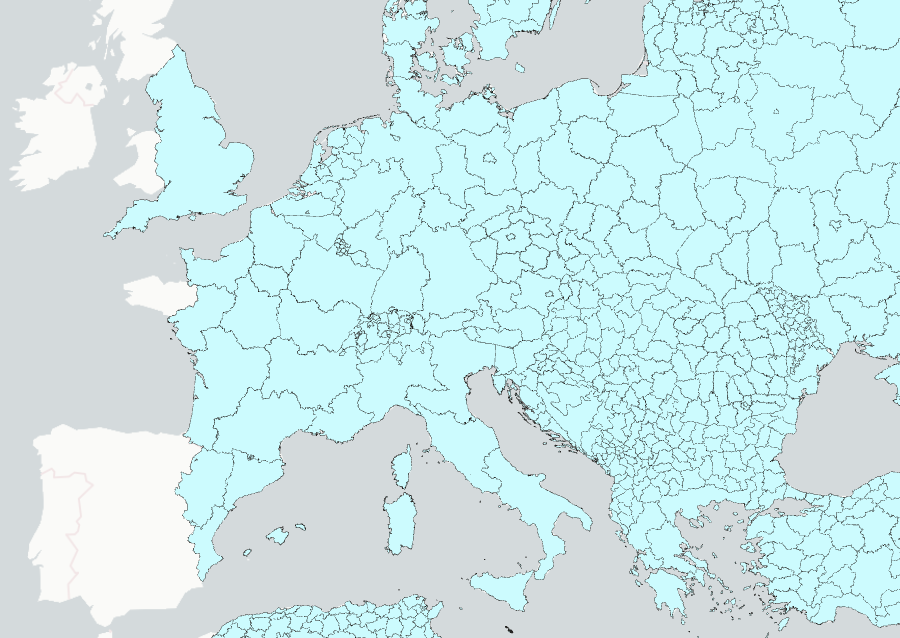


## Imports


In [1]:
! pip --quiet install pyogrio lonboard requests pyarrow geopandas tqdm


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
from pathlib import Path

import geopandas as gpd
import requests
from tqdm import tqdm

from lonboard import Map, PolygonLayer

The URL for a large data file of CGAZ at ADM1 Districts level:


In [3]:
url = "https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM1.geojson"
filepath = "geoBoundariesCGAZ_ADM1.geojson"

We'll go ahead and fetch the GeoJSON data in that format. If this notebook has already been run once and the file exists locally, we'll skip downloading it again.


In [4]:
if not Path(filepath).exists():
    # Make a GET request to download the file
    # Streaming, so we can iterate over the response and create a progress bar for this large file
    response = requests.get(url, stream=True)

    # Sizes in bytes.
    total_size = int(response.headers.get("content-length", 0))
    block_size = 1024

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(filepath, "wb") as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)

    if total_size != 0 and progress_bar.n != total_size:
        raise RuntimeError("Could not download file")

## Visualize Global Boundaries

Let's visualize this dataset.

We'll start by loading the data into GeoPandas. It's recommended to use the newer `pyogrio` library for faster data loading.


In [5]:
gdf = gpd.read_file(filepath, engine="pyogrio", use_arrow=True)

# Keep columns necessary for our visualization
cols = ["shapeName", "shapeID", "geometry"]
gdf = gdf[cols]

We can take a quick look at the shape of this data:


In [6]:
gdf.head(10)

shapeName                  shapeID  \
0  Kandahar  12653393B40111500734429   
1     Zabul  12653393B56617740339660   
2   Uruzgan  12653393B46006342616872   
3  Daykundi  12653393B78791504725813   
4    Ghanzi  12653393B29313712249365   
5   Paktika  12653393B93572570471663   
6     Khost  12653393B66876919073955   
7    Paktia  12653393B16859990709200   
8     Logar    12653393B769191277822   
9    Wardak  12653393B94990201402617   

                                            geometry  
0  POLYGON ((65.24153 32.28630, 65.12687 32.03679...  
1  POLYGON ((67.60666 31.44378, 67.70162 31.51373...  
2  POLYGON ((66.27519 32.42550, 66.35907 32.60925...  
3  POLYGON ((66.76157 33.25547, 66.92827 33.59694...  
4  POLYGON ((68.06945 32.04564, 68.06011 32.45619...  
5  MULTIPOLYGON (((68.10797 31.74752, 68.10807 31...  
6  POLYGON ((69.50619 33.02954, 69.50620 33.02954...  
7  POLYGON ((68.76070 33.41986, 68.95811 33.18136...  
8  POLYGON ((68.78347 33.62259, 68.99623 33.62635...  
9  POLYGON ((68.68691 33.72585, 68.86023 34.01301...

Without doing any simplification, the geometries in this dataset contain nearly 9 million coordinates (You can verify this with `shapely.get_num_coordinates(gdf["geometry"]).sum()`).

On recent computers, Lonboard should be able to visualize the entire dataset, but to ensure this dataset works on all computers, we'll select only rows whose geometries are at least partially in the eastern hemisphere:


In [7]:
eastern_hemisphere = gdf.cx[0:180, -90:90]

## Visualizing the data

We can use a [`PolygonLayer`](https://developmentseed.org/lonboard/latest/api/layers/polygon-layer/) to customize the rendering of this data.


In [8]:
layer = PolygonLayer.from_geopandas(
    eastern_hemisphere,
    get_line_width=20,  # width in default units (meters)
    line_width_min_pixels=0.2,  # minimum width when zoomed out
    get_fill_color=[204, 251, 254],  # light blue
    get_line_color=[37, 36, 34],  # dark border color
)

In [9]:
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=[204, 251, 254], get_line_color=[37, 36, 34], get_line_width=20.0, lin…